## 1. Import libraries and requirements

In [1]:
# Loading required packages
import spacy
import pandas as pd
import re
# import gensim
# import gensim.downloader
# from gensim.models import Word2Vec
# from gensim.test.utils import common_texts
# from gensim.models import Word2Vec
# from gensim.models.phrases import Phrases, Phraser
import nltk
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.dummy import DummyClassifier
from statistics import mean
import json
import csv
import ast
import numpy as np

from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from flair.embeddings import TransformerWordEmbeddings

from tqdm import tqdm

# Set seed
seed = np.random.seed(1)


# Select Spacy model
# Efficiency
nlp = spacy.load("en_core_web_sm")

# Accuracy
# nlp = spacy.load("en_core_web_trf")

# Change working directory
# %cd '/Users/richardfrissen/Documents/Maastricht University/Thesis/Development/Datasets'

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# Define columns and read annotated data
columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'like_num', 'lang', 'sentiment']
data = pd.read_csv('FULL_Annotation_data_output.tsv', sep='\t', nrows=500000, header = None)

In [ ]:
data[1].value_counts()

In [ ]:
y_train['Label'].value_counts()

In [ ]:
y_test[0].value_counts()

In [ ]:
%%time

# Generate linguistic features for each token
def feature_extraction(input_column):
    features = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    for i in tqdm(input_column):
        i = str(i)
        doc = nlp(i)
        word = i
        for token in doc:
            features[0].append(token.pos)
            features[1].append(token.ent_type)
            features[2].append(token.is_alpha)
            features[3].append(token.is_ascii)
            features[4].append(token.is_digit)
            features[5].append(token.is_lower)
            features[6].append(token.is_upper)
            features[7].append(token.is_title)
            features[8].append(token.is_punct)
            features[9].append(token.is_space)
            features[10].append(token.like_num)
            features[11].append(token.is_oov)
            features[12].append(token.is_stop)
            features[13].append(token.lang)
            features[14].append(token.sentiment)
            features[15].append(len(word))
    return features

features = feature_extraction(data[0])

In [ ]:
%%time

# Convert list to dataframe
features = pd.DataFrame(features)

# We need to transpose this dataframe first
features = features.transpose()

# We concat the annotated data with the linguistic features
data = pd.concat([data, features], axis=1)
data.columns = ['Token', 'Label', 'pos', 'ent_type', 'is_alpha', 'is_ascii', 'is_digit', 'is_lower', 'is_upper', 'is_title', 'is_punct', 'is_space', 'like_num', 'is_oov', 'is_stop', 'lang', 'sentiment', 'word_length']

data.head(10)

In [ ]:
# Optionally the data can be saved to create a checkpoint

data.to_csv('data_features_full_dataset.csv', index = False)

data = pd.read_csv('data_features_full_dataset.csv', nrows = 500000, header = 0)

data.shape

In [ ]:
data.head(10)

In [ ]:
# init word embedding
embedding = TransformerWordEmbeddings('bert-base-cased')

In [ ]:
%%time

# Generate word embeddings for each token

def bert_wordembed(input_column):
    bert_result =[]
    counter = 0
    for i in tqdm(input_column):
        counter = counter +1
        try:
            i = str(i)
            token = Sentence(i)
            embedding.embed(token)
            result_array = token[0].embedding
            result_list = result_array.tolist()
            bert_result.append(result_list)
        except KeyError:
            bert_result.append(np.nan)
        except TypeError: 
            bert_result.append(np.nan)
        except IndexError:
            bert_result.append(np.nan)

    return bert_result


# Bert_Word_Embeddings
word_embedding = bert_wordembed(data['Token'])

In [ ]:
len(word_embedding)

In [ ]:
# Optionally the data can be saved to create a checkpoint

# import pickle

f = open('word_embedding_bert.pckl', 'wb')
pickle.dump(word_embedding, f)
f.close()

f = open('word_embedding_bert.pckl', 'rb')
word_embedding = pickle.load(f)
f.close()

In [ ]:
%%time

# Replace empty values in the list of word embeddings for words 
# we couldn't generate a word embedding for

word_embedding_complete = []

for i in tqdm(word_embedding):
    try:
        if len(i) == 0:
            i = []
        else:
            i = i
        word_embedding_complete.append(i)
        
    except TypeError:
        i = []
        word_embedding_complete.append(i)

In [ ]:
# Check and verify length
# Length must be the same as the nrows of the dataframe

len(word_embedding_complete)

In [ ]:
%%time

# Convert list to dataframe
word_embedding_df = pd.DataFrame(word_embedding_complete)
word_embedding_series = word_embedding_df.apply(pd.Series)

# We concat the annotated data with the linguistic features
data = pd.concat([data, word_embedding_series], axis=1)

In [ ]:
data.head(10)

In [2]:
%%time

# Optionally the data can be saved to create a checkpoint

# data.to_csv('data_features_full_wordembedding_bert.csv', index = False)

data = pd.read_csv('data_features_full_wordembedding_fasttext.csv', nrows=500000, na_values=['nan'])

data.head(10)

CPU times: user 28.9 s, sys: 2.24 s, total: 31.1 s
Wall time: 32.1 s


,Token,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,...,290,291,292,293,294,295,296,297,298,299
0,food,O,92,0,True,True,False,True,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
1,a,O,90,0,True,True,False,True,False,False,...,0.428693,0.140281,-0.160824,0.140865,0.010901,-0.006161,-0.024191,0.534851,-0.055810,-0.016598
2,fast,O,86,0,True,True,False,True,False,False,...,0.088452,0.049980,-0.188911,0.008010,0.005692,0.030967,0.088043,0.132366,-0.068855,-0.109943
3,grow,O,100,0,True,True,False,True,False,False,...,0.079889,-0.001241,-0.078710,0.056499,-0.040299,0.026815,0.016724,0.003833,0.141033,0.139362
4,-winne,O,97,0,False,True,False,True,False,False,...,0.026260,-0.142785,-0.139935,0.030903,0.135329,-0.037944,-0.159724,0.062729,-0.032213,-0.062005
5,online,O,86,0,True,True,False,True,False,False,...,-0.011911,0.032228,-0.046799,-0.049946,-0.098857,0.027563,0.032633,0.078089,-0.021893,0.010680
6,food,O,92,0,True,True,False,True,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
7,community,O,92,0,True,True,False,True,False,False,...,0.001633,0.012280,-0.018961,0.068939,-0.038316,0.001767,0.018424,0.039195,0.033368,0.054643
8,and,O,89,0,True,True,False,True,False,False,...,0.060722,-0.035507,-0.023820,-0.027755,-0.026023,-0.038051,-0.021103,-0.011591,-0.041129,0.036252
9,crowd,O,92,0,True,True,False,True,False,False,...,0.037642,-0.092540,-0.013170,0.092988,0.080099,-0.030800,0.069824,0.092307,-0.001399,-0.007892


In [3]:
len(data)

500000

In [4]:
%%time

# Replace NaN values with a "0"

data = data.replace(np.nan, '0', regex=True)

# We drop the token, as it is no longer needed for prediction
data.drop('Token', axis=1, inplace=True)
data.head(10)

CPU times: user 529 ms, sys: 268 ms, total: 798 ms
Wall time: 820 ms


,Label,pos,ent_type,is_alpha,is_ascii,is_digit,is_lower,is_upper,is_title,is_punct,...,290,291,292,293,294,295,296,297,298,299
0,O,92,0,True,True,False,True,False,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
1,O,90,0,True,True,False,True,False,False,False,...,0.428693,0.140281,-0.160824,0.140865,0.010901,-0.006161,-0.024191,0.534851,-0.055810,-0.016598
2,O,86,0,True,True,False,True,False,False,False,...,0.088452,0.049980,-0.188911,0.008010,0.005692,0.030967,0.088043,0.132366,-0.068855,-0.109943
3,O,100,0,True,True,False,True,False,False,False,...,0.079889,-0.001241,-0.078710,0.056499,-0.040299,0.026815,0.016724,0.003833,0.141033,0.139362
4,O,97,0,False,True,False,True,False,False,False,...,0.026260,-0.142785,-0.139935,0.030903,0.135329,-0.037944,-0.159724,0.062729,-0.032213,-0.062005
5,O,86,0,True,True,False,True,False,False,False,...,-0.011911,0.032228,-0.046799,-0.049946,-0.098857,0.027563,0.032633,0.078089,-0.021893,0.010680
6,O,92,0,True,True,False,True,False,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
7,O,92,0,True,True,False,True,False,False,False,...,0.001633,0.012280,-0.018961,0.068939,-0.038316,0.001767,0.018424,0.039195,0.033368,0.054643
8,O,89,0,True,True,False,True,False,False,False,...,0.060722,-0.035507,-0.023820,-0.027755,-0.026023,-0.038051,-0.021103,-0.011591,-0.041129,0.036252
9,O,92,0,True,True,False,True,False,False,False,...,0.037642,-0.092540,-0.013170,0.092988,0.080099,-0.030800,0.069824,0.092307,-0.001399,-0.007892


In [5]:
%%time

# 80% / 20% split
# Train, Test = train_test_split(data1, test_size=0.2, shuffle=False)

X = data.drop(['Label'],axis=1).values # independant features
y = data['Label'].values # dependant variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

CPU times: user 5.03 s, sys: 4.38 s, total: 9.41 s
Wall time: 10 s


In [6]:
X_train.shape

(400000, 316)

In [7]:
X_test.shape

(100000, 316)

In [8]:
y_train.shape

(400000,)

In [9]:
y_test.shape

(100000,)

In [10]:
# Returning to one dataframe
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
y_train.columns = ['Label']
training_set = pd.concat([y_train, X_train], axis=1)

In [11]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,306,307,308,309,310,311,312,313,314,315
0,92,0,True,True,False,True,False,False,False,False,...,-0.039578,0.047575,-0.058627,0.046259,0.023654,0.051156,-0.025376,0.194072,0.064826,-0.043009
1,90,0,True,True,False,True,False,False,False,False,...,0.428693,0.140281,-0.160824,0.140865,0.010901,-0.006161,-0.024191,0.534851,-0.05581,-0.016598
2,86,0,True,True,False,True,False,False,False,False,...,0.088452,0.04998,-0.188911,0.00801,0.005692,0.030967,0.088043,0.132366,-0.068855,-0.109943
3,100,0,True,True,False,True,False,False,False,False,...,0.079889,-0.001241,-0.07871,0.056499,-0.040299,0.026815,0.016724,0.003833,0.141033,0.139362
4,97,0,False,True,False,True,False,False,False,False,...,0.02626,-0.142785,-0.139935,0.030903,0.135329,-0.037944,-0.159724,0.062729,-0.032213,-0.062005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,92,0,True,True,False,False,False,True,False,False,...,0.019415,-0.003815,0.055056,-0.0006,0.062356,0.004931,0.049479,0.05182,-0.087725,0.032541
399996,84,0,True,True,False,False,False,True,False,False,...,0.029766,-0.002164,-0.015043,0.038134,-0.026336,-0.027332,-0.040955,0.029151,-0.011679,0.03297
399997,92,0,True,True,False,False,False,True,False,False,...,0.041499,-0.041801,-0.143957,-0.065888,-0.049115,-0.046745,-0.004242,0.542329,-0.062437,0.090048
399998,97,0,False,True,False,False,False,False,True,False,...,0.016919,-0.043851,-0.057783,0.022305,-0.077707,-0.0432,-0.025055,0.237025,0.000448,-0.004193


In [12]:
y_train

,Label
0,O
1,O
2,O
3,O
4,O
...,...
399995,O
399996,O
399997,O
399998,O


In [13]:
y_train.value_counts()

Label                          
O                                  384869
Feminine-coded words                 7291
Masculine-coded words                7111
Exclusive language                    483
Demographic and Racial language       228
LGBTQ-coloured language                18
dtype: int64

In [14]:
# Separate majority and minority classes
df_O = training_set[training_set.iloc[:,0]=="O"]
df_Feminine = training_set[training_set.iloc[:,0]=="Feminine-coded words"]
df_Masculine = training_set[training_set.iloc[:,0]=="Masculine-coded words"]
df_Exclusive = training_set[training_set.iloc[:,0]=="Exclusive language"]
df_Demographic = training_set[training_set.iloc[:,0]=="Demographic and Racial language"]
df_LGBTQ = training_set[training_set.iloc[:,0]=="LGBTQ-coloured language"]

In [15]:
# Undersampling the majority
undersample_O = resample(df_O, 
                       replace=True, 
                       n_samples=248690, #set the number of samples to equal the number of the minority class
                       random_state=42)

In [16]:
# Oversampling the minority
oversample_Feminine = resample(df_Feminine, 
                       replace=True, 
                       n_samples=72910, #set the number of samples to equal the number of the majority class
                       random_state=42)

In [17]:
# Oversampling the minority
oversample_Masculine = resample(df_Masculine, 
                       replace=True, 
                       n_samples=71110, #set the number of samples to equal the number of the majority class
                       random_state=42)

In [18]:
# Oversampling the minority
oversample_Exclusive = resample(df_Exclusive, 
                       replace=True, 
                       n_samples=4830, #set the number of samples to equal the number of the majority class
                       random_state=42)

In [19]:
# Oversampling the minority
oversample_Demographic = resample(df_Demographic, 
                       replace=True, 
                       n_samples=2280, #set the number of samples to equal the number of the majority class
                       random_state=42)

In [20]:
# Oversampling the minority
oversample_LGBTQ = resample(df_LGBTQ, 
                       replace=True, 
                       n_samples=180, #set the number of samples to equal the number of the majority class
                       random_state=42)

In [21]:
new_train = pd.concat([undersample_O, oversample_Exclusive, oversample_Feminine, oversample_Masculine, oversample_Demographic, oversample_LGBTQ])

In [22]:
new_train

,Label,0,1,2,3,4,5,6,7,8,...,306,307,308,309,310,311,312,313,314,315
126700,O,89,0,True,True,False,True,False,False,False,...,-0.057575,0.117147,-0.052318,0.006972,0.01247,-0.000695,-0.06065,0.099221,-0.030719,-0.01661
152533,O,92,0,True,True,False,True,False,False,False,...,0.428693,0.140281,-0.160824,0.140865,0.010901,-0.006161,-0.024191,0.534851,-0.05581,-0.016598
136999,O,85,0,False,True,False,True,False,False,False,...,0.09348,-0.055356,-0.073151,-0.035189,0.027524,-0.076996,0.051897,0.046359,-0.003545,0.035528
380257,O,97,0,False,True,False,False,False,False,True,...,0.016919,-0.043851,-0.057783,0.022305,-0.077707,-0.0432,-0.025055,0.237025,0.000448,-0.004193
269301,O,96,0,True,True,False,True,False,False,False,...,0.067105,0.012743,-0.069099,0.05388,-0.047717,0.034367,-0.000115,0.113491,-0.010051,-0.039871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28908,LGBTQ-coloured language,90,0,True,True,False,True,False,False,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621
214229,LGBTQ-coloured language,96,384,True,True,False,False,False,True,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621
176655,LGBTQ-coloured language,92,0,True,True,False,True,False,False,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621
316588,LGBTQ-coloured language,100,0,True,True,False,True,False,False,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621


In [23]:
new_train.shape

(400000, 317)

In [24]:
# Drop target variable
X_train = new_train.drop(['Label'], axis=1)
X_train

,0,1,2,3,4,5,6,7,8,9,...,306,307,308,309,310,311,312,313,314,315
126700,89,0,True,True,False,True,False,False,False,False,...,-0.057575,0.117147,-0.052318,0.006972,0.01247,-0.000695,-0.06065,0.099221,-0.030719,-0.01661
152533,92,0,True,True,False,True,False,False,False,False,...,0.428693,0.140281,-0.160824,0.140865,0.010901,-0.006161,-0.024191,0.534851,-0.05581,-0.016598
136999,85,0,False,True,False,True,False,False,False,False,...,0.09348,-0.055356,-0.073151,-0.035189,0.027524,-0.076996,0.051897,0.046359,-0.003545,0.035528
380257,97,0,False,True,False,False,False,False,True,False,...,0.016919,-0.043851,-0.057783,0.022305,-0.077707,-0.0432,-0.025055,0.237025,0.000448,-0.004193
269301,96,0,True,True,False,True,False,False,False,False,...,0.067105,0.012743,-0.069099,0.05388,-0.047717,0.034367,-0.000115,0.113491,-0.010051,-0.039871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28908,90,0,True,True,False,True,False,False,False,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621
214229,96,384,True,True,False,False,False,True,False,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621
176655,92,0,True,True,False,True,False,False,False,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621
316588,100,0,True,True,False,True,False,False,False,False,...,-0.002679,0.006351,-0.014082,0.071826,-0.028164,0.00405,-0.009827,0.066083,-0.020313,0.06621


In [25]:
y_train = new_train['Label']
y_train

126700                          O
152533                          O
136999                          O
380257                          O
269301                          O
                   ...           
28908     LGBTQ-coloured language
214229    LGBTQ-coloured language
176655    LGBTQ-coloured language
316588    LGBTQ-coloured language
105561    LGBTQ-coloured language
Name: Label, Length: 400000, dtype: object

In [26]:
y_train.value_counts()

O                                  248690
Feminine-coded words                72910
Masculine-coded words               71110
Exclusive language                   4830
Demographic and Racial language      2280
LGBTQ-coloured language               180
Name: Label, dtype: int64

In [27]:
# Delete data to save memory
# Separate majority and minority classes
del(df_O)
del(df_Feminine)
del(df_Masculine)
del(df_Exclusive)
del(df_Demographic)
del(df_LGBTQ)
del(new_train)
del(data)

In [28]:
X_train.shape

(400000, 316)

In [29]:
y_train = y_train.values.ravel()
# X_train = X_train.values.ravel()

In [30]:
X_train.shape, y_train.shape

((400000, 316), (400000,))

In [31]:
X_test.shape, y_test.shape

((100000, 316), (100000,))

In [32]:
%%time

max_iterations = 1000000000

classifier = []
accuracy = []
precision = []
recall = []
f1 = []

CPU times: user 9 µs, sys: 4 µs, total: 13 µs
Wall time: 26 µs


In [33]:
%%time
# Baseline

clf = DummyClassifier(strategy="uniform", random_state=seed)


# Model fit
clf.fit(X_train, y_train)

CPU times: user 232 ms, sys: 1.96 ms, total: 234 ms
Wall time: 235 ms


DummyClassifier(strategy='uniform')

In [34]:
# Optionally the data can be saved to create a checkpoint - Baseline

import pickle

f = open('fasttext_baseline_resample_2.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_baseline_resample_2.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.16662
Precision: 0.16669788143411368
Recall: 0.16315833387324433
F1_score: 0.05833372562723548


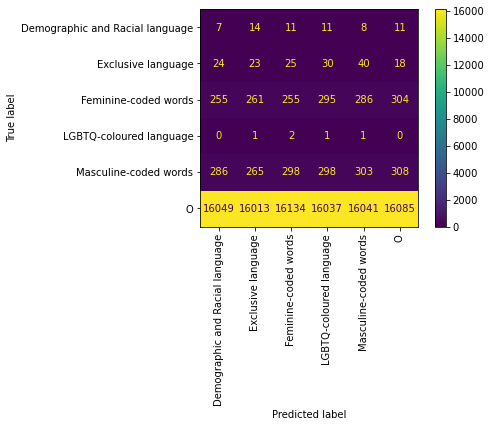

                                 precision    recall  f1-score   support

Demographic and Racial language       0.00      0.15      0.00        62
             Exclusive language       0.00      0.13      0.00       160
           Feminine-coded words       0.02      0.18      0.03      1656
        LGBTQ-coloured language       0.00      0.20      0.00         5
          Masculine-coded words       0.02      0.15      0.03      1758
                              O       0.96      0.17      0.28     96359

                       accuracy                           0.17    100000
                      macro avg       0.17      0.16      0.06    100000
                   weighted avg       0.93      0.17      0.27    100000



In [35]:
# Evaluation Baseline

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("Baseline")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal SVM parameters

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# gammas = [0.001, 0.01, 0.1, 1]
# param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': ('linear', 'rbf', 'poly', 'sigmoid')}
# grid_search = GridSearchCV(svm.SVC(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [ ]:
%%time
# Support Vector Machine
# best: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = svm.SVC(kernel='rbf', random_state=seed, max_iter=max_iterations, C=10, gamma=1)
scores_SVM = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
SVM_avg_precision = mean(scores_SVM['test_precision_macro'])
SVM_avg_recall = mean(scores_SVM['test_recall_macro'])
SVM_avg_f1 = mean(scores_SVM['test_f1_macro'])

print(SVM_avg_precision)
print(SVM_avg_recall)
print(SVM_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [ ]:
# Optionally the data can be saved to create a checkpoint - SVM

import pickle

f = open('bert_svm.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_svm.pckl', 'rb')
clf = pickle.load(f)
f.close()

In [ ]:
# Evaluation Support Vector Machine

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("SVM")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Logistic Regression settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# Cs = [0.001, 0.01, 0.1, 1, 10]
# penaltys = ['l1', 'l2', 'elasticnet']
# param_grid = {'C': Cs, 'penalty' : penaltys, 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
# grid_search = GridSearchCV(LogisticRegression(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [ ]:
%%time

# Logistic Regression

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = LogisticRegression(solver='newton-cg', random_state=seed, max_iter=max_iterations)
scores_LR = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
LR_avg_precision = mean(scores_LR['test_precision_macro'])
LR_avg_recall = mean(scores_LR['test_recall_macro'])
LR_avg_f1 = mean(scores_LR['test_f1_macro'])

print(LR_avg_precision)
print(LR_avg_recall)
print(LR_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [ ]:
# Optionally the data can be saved to create a checkpoint - LR

import pickle

f = open('bert_lr.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_lr.pckl', 'rb')
clf = pickle.load(f)
f.close()

In [ ]:
# Evaluation Logistic Regression

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("LR")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Decision Tree

# Cross validation
scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = DecisionTreeClassifier(random_state=seed)
scores_DT = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
DT_avg_precision = mean(scores_DT['test_precision_macro'])
DT_avg_recall = mean(scores_DT['test_recall_macro'])
DT_avg_f1 = mean(scores_DT['test_f1_macro'])

print(DT_avg_precision)
print(DT_avg_recall)
print(DT_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [ ]:
# Optionally the data can be saved to create a checkpoint - DT

import pickle

f = open('bert_dt.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_dt.pckl', 'rb')
clf = pickle.load(f)
f.close()

In [ ]:
# Evaluation Decision Tree

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("DT")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [36]:
%%time

# Random Forest

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = RandomForestClassifier(random_state=seed)
scores_RF = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
RF_avg_precision = mean(scores_RF['test_precision_macro'])
RF_avg_recall = mean(scores_RF['test_recall_macro'])
RF_avg_f1 = mean(scores_RF['test_f1_macro'])

print(RF_avg_precision)
print(RF_avg_recall)
print(RF_avg_f1)

# Model fit
clf.fit(X_train, y_train)

0.999879227734839
0.9999651507231225
0.9999221713164745
CPU times: user 5min 57s, sys: 57.3 s, total: 6min 55s
Wall time: 10min 58s


RandomForestClassifier()

In [37]:
# Optionally the data can be saved to create a checkpoint - RF

import pickle

f = open('fasttext_rf_resample_2.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('fasttext_rf_resample_2.pckl', 'rb')
clf = pickle.load(f)
f.close()

Accuracy: 0.99977
Precision: 0.9962649786373327
Recall: 0.9296070705637086
F1_score: 0.9545771322634568


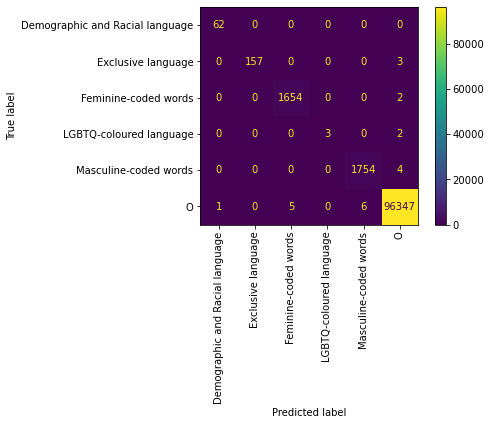

                                 precision    recall  f1-score   support

Demographic and Racial language       0.98      1.00      0.99        62
             Exclusive language       1.00      0.98      0.99       160
           Feminine-coded words       1.00      1.00      1.00      1656
        LGBTQ-coloured language       1.00      0.60      0.75         5
          Masculine-coded words       1.00      1.00      1.00      1758
                              O       1.00      1.00      1.00     96359

                       accuracy                           1.00    100000
                      macro avg       1.00      0.93      0.95    100000
                   weighted avg       1.00      1.00      1.00    100000



In [38]:
# Evaluation Random Forest

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("RF")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Find optimal Neural network MLP settings

# from sklearn import svm
# from sklearn.model_selection import GridSearchCV

# activations = ['identity', 'logistic', 'tanh', 'relu']
# alphas = [0.0001, 0.001, 00.1, 0.1, 1]
# param_grid = {'activation': activations, 'alpha' : alphas, 'solver': ('lbfgs', 'sgd', 'adam'), 'learning_rate': ('constant', 'invscaling', 'adaptive')}
# grid_search = GridSearchCV(MLPClassifier(random_state=seed), param_grid, cv=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# print(grid_search.best_params_)

In [ ]:
%%time

# Neural network MLP

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = MLPClassifier(solver='adam', random_state=seed)
scores_NN = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NN_avg_precision = mean(scores_NN['test_precision_macro'])
NN_avg_recall = mean(scores_NN['test_recall_macro'])
NN_avg_f1 = mean(scores_NN['test_f1_macro'])

print(NN_avg_precision)
print(NN_avg_recall)
print(NN_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [ ]:
# Optionally the data can be saved to create a checkpoint - MLP

import pickle

f = open('bert_mlp.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_mlp.pckl', 'rb')
clf = pickle.load(f)
f.close()

In [ ]:
# Evaluation Neural network MLP

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("MLP")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [ ]:
%%time

# Naive Bayes

scoring = ['precision_macro', 'recall_macro', "f1_macro"]
clf = GaussianNB()
scores_NB = cross_validate(clf, X_train, y_train, scoring = scoring, cv=10, n_jobs=-1)
NB_avg_precision = mean(scores_NB['test_precision_macro'])
NB_avg_recall = mean(scores_NB['test_recall_macro'])
NB_avg_f1 = mean(scores_NB['test_f1_macro'])

print(NB_avg_precision)
print(NB_avg_recall)
print(NB_avg_f1)

# Model fit
clf.fit(X_train, y_train)

In [ ]:
# Optionally the data can be saved to create a checkpoint - NB

import pickle

f = open('bert_nb.pckl', 'wb')
pickle.dump(clf, f)
f.close()

f = open('bert_nb.pckl', 'rb')
clf = pickle.load(f)
f.close()

In [ ]:
# Evaluation Naive Bayes

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro',zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1_score:", f1_score(y_test, y_pred, average='macro'))

classifier.append("NB")
accuracy.append(accuracy_score(y_test, y_pred))
precision.append(precision_score(y_test, y_pred, average='macro',zero_division=0))
recall.append(recall_score(y_test, y_pred, average='macro'))
f1.append(f1_score(y_test, y_pred, average='macro'))

plot_confusion_matrix(clf, X_test, y_test, xticks_rotation='vertical')
plt.show()

print(classification_report(y_test,y_pred))

In [39]:
results = pd.DataFrame(zip(classifier, accuracy, precision, recall, f1), columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
results = results.sort_values(by = "F1-score", ascending = False)

f = open('fasttext_results_resample_2.pckl', 'wb')
pickle.dump(results, f)
f.close()

f = open('fasttext_results_resample_2.pckl', 'rb')
results = pickle.load(f)
f.close()

print(results)

  Classifier  Accuracy  Precision    Recall  F1-score
1         RF   0.99977   0.996265  0.929607  0.954577
0   Baseline   0.16662   0.166698  0.163158  0.058334


In [40]:
# Save results dataframe

results.to_csv('fasttext_results_resample_2.csv', index = False)